In [1]:
# Import des Package

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Utilisation du DF data_features qui contient toute les données nettoyées et le climat koppen intégré

df = pd.read_csv('data_features.csv', sep=',', index_col=0) 
df.head()

,sunshine,windgustspeed,humidity3pm,pressure3pm,year,windspeed3pm,temp_amplitude,cloud3pm,rainfall,climat,...,cloud9am,winddir9am_sin,latitude,month,geography,raintoday,evaporation,windspeed9am,windgustdir_cos,raintomorrow
0,10.9,44.0,22.0,1007.1,2008,24.0,9.5,7.0,0.6,0,...,8.0,1.224647e-16,-36.065766,12,0,0,7.6,20.0,-1.000000,0
1,12.9,44.0,25.0,1007.8,2008,22.0,17.7,1.0,0.0,0,...,1.0,9.238795e-01,-36.065766,12,0,0,12.0,4.0,-0.923880,0
2,8.0,46.0,30.0,1008.7,2008,26.0,12.8,2.0,0.0,0,...,7.0,1.224647e-16,-36.065766,12,0,0,8.0,19.0,-0.923880,0
3,2.2,24.0,16.0,1012.8,2008,9.0,18.8,6.0,0.0,0,...,8.0,-7.071068e-01,-36.065766,12,0,0,10.0,11.0,0.707107,0
4,6.7,41.0,33.0,1006.0,2008,20.0,14.8,8.0,1.0,0,...,7.0,3.826834e-01,-36.065766,12,0,0,4.8,7.0,-1.000000,0


In [4]:
# supprimer les lignes qui contiennent des valeurs manquantes
df1 = df.dropna()

# séparer la variable cible du jeu de dconnée
target = df1["raintomorrow"]
data = df1.drop("raintomorrow", axis=1) 

In [7]:
# fonction "train_test_split()" pour diviser les données en un ensemble d'entraînement et de test.
# 80 % des données sont utilisées pour l'apprentissage et 20 % pour le test.

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [8]:
# optimisation bayésienne des hyperparamètres d'un modèle RandomForestClassifier.


# Définition de l'espace de recherche pour l'optimisation bayésienne
space = {
    'n_estimators': Integer(100, 1000), # nombre d'arbres dans la forêt aléatoire
    'max_depth': Integer(3, 15), # profondeur maximale de chaque arbre dans la forêt aléatoire
    'min_samples_split': Integer(2, 10), # nombre minimal d'échantillons requis pour diviser un nœud interne.
    'min_samples_leaf': Integer(1, 5), # nombre minimal d'échantillons requis pour être à une feuille
    'max_features': Real(0.1, 1.0, prior='uniform') # nombre max de caractéristiques lors de la recherche de la meilleure division
}




In [9]:
# Définition du modèle à optimiser (Random Forest)
model = RandomForestClassifier()




In [10]:
# Définition de l'optimiseur bayésien avec 20 itérations
opt = BayesSearchCV(
    model, # estimateur à utiliser pour l'optimisation bayésienne
    space, # espace de recherche pour l'optimisation bayésienne, défini précédemment dans le code
    n_iter=20, # nombre d'itérations à effectuer. Plus le nombre d'itérations est grand, plus la recherche sera précise
    scoring='accuracy', # c'est la métrique de performance à utiliser pour évaluer les modèles
    n_jobs=-1, # nombre de tâches à exécuter en parallèle. valeur -1 signifie que toutes les ressources disponibles sont utilisées.
    cv=5 # nombre de plis à utiliser lors de la validation croisée
)

# Lancement de l'optimisation
opt.fit(X_train, y_train)



BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
              scoring='accuracy',
              search_spaces={'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')})

In [11]:
# Affichage des meilleurs hyperparamètres trouvés
print('Meilleurs hyperparamètres :', opt.best_params_)

# Évaluation du modèle avec les hyperparamètres trouvés
score = opt.score(X_test, y_test)
print('Score de l\'optimisation bayésienne : {:.2f}'.format(score))

Meilleurs hyperparamètres : OrderedDict([('max_depth', 15), ('max_features', 0.5385638830477314), ('min_samples_leaf', 1), ('min_samples_split', 9), ('n_estimators', 964)])
Score de l'optimisation bayésienne : 0.88


In [12]:
# Instanciation du modèle avec les meilleurs hyperparamètres
best_model = RandomForestClassifier(
    max_depth=15,
    max_features=0.5385638830477314,
    min_samples_leaf=1,
    min_samples_split=9,
    n_estimators=964
)

# Entraînement du modèle sur l'ensemble des données d'entraînement
best_model.fit(X_train, y_train)

# Évaluation du modèle sur l'ensemble des données de test
score = best_model.score(X_test, y_test)
print('Score du modèle Accuracy avec les best hyperparametres : {:.2f}'.format(score))

Score du modèle Accuracy avec les best hyperparametres : 0.88


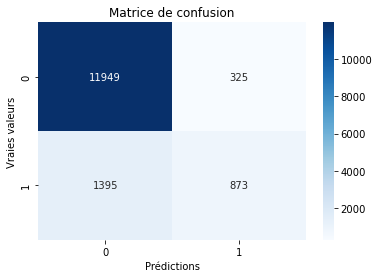

In [18]:

# Évaluation du modèle sur l'ensemble des données de test
y_pred = best_model.predict(X_test)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec Seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Configuration de l'affichage
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

In [ ]:
"""
La matrice de confusion est donc une matrice 2x2 qui permet de compter le nombre de prédictions 
correctes et incorrectes effectuées par un modèle de classification. 
Elle peut être utilisée pour calculer différentes métriques d'évaluation
"""

In [ ]:
"""
L'accuracy mesure la proportion de prédictions correctes par rapport au nombre total de prédictions.
Elle est utile lorsque les classes sont équilibrées (c'est-à-dire qu'il y a un nombre similaire d'exemples dans chaque classe). 
Cependant, l'accuracy peut être trompeuse si les classes sont déséquilibrées, 
car le modèle peut prédire la classe majoritaire tout le temps et obtenir une accuracy élevée sans être utile.
"""

In [13]:
# Meme chose avec le F1 weighted comme metric


from sklearn.metrics import f1_score, make_scorer

# Définition de l'espace de recherche pour l'optimisation bayésienne
space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 15),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Real(0.1, 1.0, prior='uniform')
}

# Définition de la fonction de score personnalisée
scorer = make_scorer(f1_score, average='weighted')









In [14]:
# Définition de l'optimiseur bayésien avec 20 itérations
opt = BayesSearchCV(
    RandomForestClassifier(),
    space,
    n_iter=20,
    scoring=scorer,
    n_jobs=-1,
    cv=5
)

# Lancement de l'optimisation
opt.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
              scoring=make_scorer(f1_score, average=weighted),
              search_spaces={'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')})

In [15]:
# Affichage des meilleurs hyperparamètres trouvés
print('Meilleurs hyperparamètres :', opt.best_params_)

# Calcul des prédictions sur l'ensemble de test
y_pred = opt.predict(X_test)

# Calcul du score F1 weighted
score = f1_score(y_test, y_pred, average='weighted')
print('F1 score weighted du modèle :', score)

Meilleurs hyperparamètres : OrderedDict([('max_depth', 15), ('max_features', 1.0), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 100)])
F1 score weighted du modèle : 0.8649984548279794


In [25]:
# Instanciation du modèle avec les meilleurs hyperparamètres

# Définition des hyperparamètres
hyperparams = {
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 2,
    'min_samples_leaf': 5,
    'max_features': 1.0
}


# Entraînement du modèle
model.fit(X_train, y_train)



RandomForestClassifier(max_depth=15, max_features=1.0, min_samples_leaf=5)

In [17]:
# Calcul des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul du score F1 weighted
score = f1_score(y_test, y_pred, average='weighted')
print('Score du F1 weighted  avec les best parametres :', score)

Score du F1 weighted  avec les best parametres : 0.8648431914062747


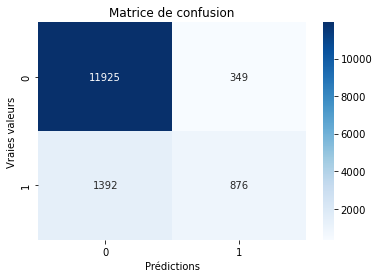

In [20]:
# Calcul des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec Seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Configuration de l'affichage
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()



In [ ]:
"""
Le F1-score est une métrique qui combine la précision et le rappel. 
Le rappel mesure la proportion de vrais positifs parmi tous les exemples de la classe positive, 
tandis que la précision mesure la proportion de vrais positifs parmi les prédictions positives. 
Le F1-score est la moyenne harmonique de la précision et du rappel, et il est souvent utilisé lorsque les classes sont déséquilibrées.

Le F1-weighted est une variante du F1-score qui tient compte du nombre d'exemples dans chaque classe.
Il est donc plus approprié lorsque les classes sont déséquilibrées, 
car il accorde plus de poids aux classes qui ont un plus grand nombre d'exemples.
"""